# Recipe Recommendations

### Written by Nicholas Cejda for Text Analytics Spring 2020 - Final Project

This program is designed to accept a user's list of ingredients, say "salsa", "tortilla", and "beef", and predict the style of cuisine those ingredients most belong to, as well as recommending recipes which utilize as many of the listed ingredients as possible. The user is able to select how many recipes they would like to display.

This is achieved by first generating 'Word Vectors' for each word in the Training dataset's (80% of the full dataset) recipe lists, using Spacy's "en_core_web_lg" model, which contains word vectors for many food words. I then took an average of all the word vectors within a recipe to generate 300 numerical features for each recipe. From there, I used the K-Nearest Neighbor's (KNN) approach to train a classifer. I then evaluated the performance of my classifer using the test data (the remaining 20%). It performs with an average accuracy of 71% across all the classes, doing better on the larger classes, and slightly worse on the smaller classes. This represents a 51 point increase in accuracy from a naiive base model (which will simply always select the largest class). Finally, I used this classifer to predict the cuisine style of the user's ingredients.  

In [1]:
import spacy
import json
import os
import sklearn
import pandas as pd
from matplotlib import pyplot
import numpy as np
import re
import random

In [2]:
jsonPath = os.path.abspath(os.path.curdir) + '/docs/yummly.json'
with open(jsonPath, 'r') as file:
    yum = json.load(file)

print("Total number of rows: " + str(len(yum))) #39,774 recepies are in this .json dataset.
yumdf = pd.DataFrame(yum)
yumdf.head()

Total number of rows: 39774


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
#Let's look at how many items are in each cuisine style:

dishes_by_cuisine = yumdf.groupby('cuisine')
cuisine_count = dishes_by_cuisine.id.nunique()
cultures = yumdf.cuisine.unique()
cultures.sort()
cuisine_count

cuisine
brazilian        467
british          804
cajun_creole    1546
chinese         2673
filipino         755
french          2646
greek           1175
indian          3003
irish            667
italian         7838
jamaican         526
japanese        1423
korean           830
mexican         6438
moroccan         821
russian          489
southern_us     4320
spanish          989
thai            1539
vietnamese       825
Name: id, dtype: int64

<BarContainer object of 20 artists>

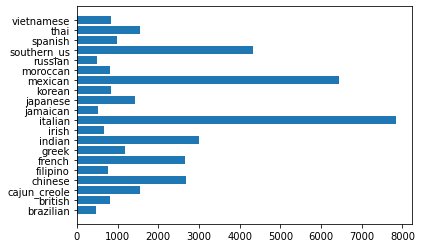

In [4]:
pyplot.barh(cultures, cuisine_count)

In [5]:
# I think the first task is to build a list of word vectors for the first recipie.

nlp = spacy.load("en_core_web_lg")

In [6]:

#Ok, the next step is to save the word vectors as an addtional column in yumdf.
#This loop takes some time, but it works. I will save the resulting dataframe to a file so that I don't have to run this block
#everytime, I can just load in the file with the word vectors.

vecList = []

for i in range (0,len(yumdf)):
    
    myText = yumdf['ingredients'][i]
    myString = " "
    myText = myString.join(myText)
    smallVecList = []
    
    doc = nlp(myText)
    
    for token in doc:
        smallVecList.append(token.vector)
        
    vecList.append(smallVecList)
    
    if i % 5000 == 0:
        print("Word Vectors generated for " + str(i) + " recipes (" + str(round(i/(len(yumdf)-1), ndigits=4)*100) + "% complete)")
    if i == len(yumdf)-1:
        print("Word Vectors generated for " + str(i) + " recipes (" + str(round(i/(len(yumdf)-1), ndigits=4)*100) + "% complete)")
    

yumdf['WordVecs'] = vecList


Word Vectors generated for 0 recipes (0.0% complete)
Word Vectors generated for 5000 recipes (12.57% complete)
Word Vectors generated for 10000 recipes (25.14% complete)
Word Vectors generated for 15000 recipes (37.71% complete)
Word Vectors generated for 20000 recipes (50.29% complete)
Word Vectors generated for 25000 recipes (62.86000000000001% complete)
Word Vectors generated for 30000 recipes (75.42999999999999% complete)
Word Vectors generated for 35000 recipes (88.0% complete)
Word Vectors generated for 39773 recipes (100.0% complete)


In [7]:
yumdf.head()

,id,cuisine,ingredients,WordVecs
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[[-0.021121, 0.089282, 0.10475, -0.2653, 0.250..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[[0.034424, -0.069366, -0.36663, 0.12511, -0.2..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[[-0.41781, -0.035192, -0.12615, -0.21593, -0...."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[[-0.036665, 0.20106, 0.2851, -0.43246, -0.395..."
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[[-0.29365, -0.049916, 0.096439, -0.089388, 0...."


In [8]:
outpath = os.path.abspath(os.path.curdir) + '/docs/pickleyumdf.csv'
yumdf.to_pickle(outpath)

# After you run the blocks above, you can start here! Just load the pandas pickle file which has the word vectors already created.

In [9]:
#  Start here! No need to re-run the block above over and over. We saved the word vectors in the file pickleyumdf.csv
inpath = os.path.abspath(os.path.curdir) + '/docs/pickleyumdf.csv'
yumdf = pd.read_pickle(inpath)

In [10]:
# The first thing we need to do is to get these wordvectors into useable Features for ML. Right now, we have for each row,
# a list of lists of size (# of words in ingredient list), 300. This variable number of lists is a problem.
# We want exactly 300 features for each row in our dataframe.

# To achieve this, we will need to create a AVERAGE word vector from all the word vectors included in the recipie.
# I'm not sure if this will be sufficient, but it's a good enough start.
# We will do this component-by-component.
# Ex, to average [2,4] and [1,6] we will get [(2+1)/2, (4+6)/2] = [1.5,5]  --> Same will apply for a 300d vector.

# Thankfully, numpy is designed to do exactly this, with the np.mean() function. We can specify our axis to find the mean
# component-by-component.

allAvgWordVecs = np.zeros(shape = (len(yumdf),300))
for i in range(0,len(yumdf)):
    
    allAvgWordVecs[i] = np.mean(yumdf['WordVecs'][i], axis = 0)
    
    
yumML = pd.DataFrame(allAvgWordVecs)
yumML.insert(0, 'Class', yumdf['cuisine'])
yumML

,Class,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,greek,-0.357424,0.133921,0.151139,-0.030118,0.118781,0.760498,-0.595350,0.048142,0.042757,...,0.151123,0.079188,-0.496163,-0.314276,-0.503333,-0.070321,-0.013351,-0.981625,0.186138,0.002184
1,southern_us,-0.347635,0.156123,0.038050,-0.063862,-0.054547,0.534082,-0.651270,0.102931,-0.196198,...,-0.046710,0.041735,-0.218796,-0.397226,-0.522850,0.159361,0.051261,-0.651906,0.096258,0.134384
2,filipino,-0.415779,0.006664,0.208394,0.116252,-0.095536,0.651770,-0.488541,0.097564,0.174845,...,0.296671,0.039015,-0.367839,-0.291567,-0.435212,0.106063,-0.014323,-0.710532,0.181928,0.222449
3,indian,-0.380033,0.089646,0.245204,-0.098342,-0.330696,0.450577,-0.640336,0.338502,-0.534054,...,-0.158510,-0.037428,-0.111374,-0.527406,-0.397198,0.225322,-0.110504,-0.699606,-0.065752,0.001312
4,indian,-0.246719,0.094627,0.100140,0.198657,0.008106,0.476092,-0.616106,0.083198,0.164462,...,0.193553,-0.031367,-0.320519,-0.443571,-0.417977,0.059895,-0.035736,-0.716559,0.126535,0.114418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,irish,-0.148402,0.254358,0.002764,-0.118501,-0.225193,0.156706,-0.468707,0.263514,-0.069579,...,-0.048996,0.038167,-0.023907,-0.317800,-0.437515,0.313882,-0.069390,-0.532498,-0.072899,0.172456
39770,italian,-0.336287,0.147571,0.090840,-0.003410,0.073805,0.591641,-0.360835,0.117172,-0.006910,...,0.109120,0.115617,-0.160705,-0.320864,-0.515978,0.004729,0.219515,-0.705649,0.091139,0.154519
39771,irish,-0.096246,0.214637,-0.002196,-0.073957,-0.232208,0.252455,-0.644834,0.190068,0.038410,...,0.121196,0.076798,-0.196457,-0.324172,-0.471355,0.150735,0.134287,-0.851964,-0.136794,0.167540
39772,chinese,-0.268682,0.081753,0.085484,0.002557,-0.022478,0.413663,-0.598197,0.090406,0.050965,...,0.108428,0.056509,-0.266308,-0.270947,-0.452627,0.074713,-0.008102,-0.710861,0.117554,0.242426


## Looks good, we have 300 features and a labeled class to train on for each recipe. The features represent the Average word vector for all words used in that recipe.

In [13]:
#With extra time, I could try out these various ML models:

# Random Forest
# Support Vector Machine
# K Nearest Neighbors
# Multinomial Naïve Bayes
# Multinomial Logistic Regression
# Gradient Boosting
# Deep learning

#For now, just go with K-nearest neighbors.

# We need to split up our data into a Training set and a Test set.
# According to Google's Best ML Practices, they say if you have a few classes that are very small , 
# like in our case Russian and Brazillian cuisine,
# then make sure you still have at least 100 rows for each of these classes in your training set.
# This will help us avoid overtraining on the majority classes and undertraining on the minority classes.

In [14]:
X = yumML.iloc[:, 1:].values
y = yumML.iloc[:, 0].values

In [15]:
print(X.shape)
print(y.shape)

(39774, 300)
(39774,)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 16)

In [17]:
class_check = pd.DataFrame(y_train)
class_check.groupby(0).size() #OK, nice. My random training dataset has all the classes, and in pretty decent numbers.

0
brazilian        366
british          651
cajun_creole    1255
chinese         2139
filipino         626
french          2103
greek            939
indian          2399
irish            545
italian         6256
jamaican         420
japanese        1146
korean           668
mexican         5135
moroccan         653
russian          404
southern_us     3439
spanish          791
thai            1216
vietnamese       668
dtype: int64

## I will start with the K-Nearest Neighbors approach for classifying our data.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 8)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='uniform')

In [20]:
y_pred = classifier.predict(X_test)

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_test,y_pred)
print("Accuracy:",result2)


Confusion Matrix:
[[  51    1   11    2    2    2    0    4    0    7    1    0    0    8
     0    0    4    6    2    0]
 [   1   53    6    2    0   15    3    0   11   25    1    0    0    1
     1    1   33    0    0    0]
 [   1    1  202    1    0    3    0    2    0   25    2    0    0    7
     1    0   44    2    0    0]
 [   2    2    7  440    4    8    0    4    0    8    0    8   14    6
     0    0    7    0   17    7]
 [   3    2    5   25   57    4    0    2    0    5    3    0    0    7
     0    1    7    0    4    4]
 [   1    9   21    2    1  286    4    2    6  149    1    3    0    6
     1    2   46    2    1    0]
 [   0    0    5    0    0    7  123    4    2   75    0    1    0    7
     6    0    5    1    0    0]
 [   1    2    4    8    3    4    3  510    2   10    2    1    1   14
    12    1    8    1   16    1]
 [   1   10    8    2    0    9    4    3   39   17    0    0    0    2
     0    0   27    0    0    0]
 [   2    6   15    3    1   74   26 

## Our K-Nearest Neighbors with default parameters yields 71% accuracy - not amazing but much better than simple random guessing!

### Our base model (complete naiive) would select the majority class, Italian, every time which represents about ~20% of cases. So we should expect a worst-case floor of 20% accuracy.

### So, our model is 51% more accurate than the base model. Not too bad for now.


## Here is where I will accept input - and generate word vecs for the user inputted words, and predict the cuisine style.

In [92]:
# This block cleans up our results to make it tab-seperated, so we can access the numbers inside.
result_tab = re.sub(r" [ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?[ ]?", r" ", result1)
result_tab = re.sub(r"^ p", "cuisine p", result_tab)
result_tab = re.sub(r"\n\n", r"\n", result_tab)
result_tab = re.sub(r"\n ", r"\n", result_tab)
result_tab = re.sub(r" ", r"\t", result_tab)
result_tab = re.sub(r"accuracy\t\t", r"accuracy\tNaN\tNaN\t", result_tab)
result_tab = re.sub(r"macro\tavg", r"macro_avg", result_tab)
result_tab = re.sub(r"weighted\tavg", r"weighted_avg", result_tab)

with open('results.csv', 'w') as file:
    file.write(result_tab)

modeldf = pd.read_csv("results.csv", sep = '\t')

In [22]:
nlp = spacy.load("en_core_web_lg")

In [23]:
#Our Cuisine Prediction method.

def predictCuisine(userInputList):

    
    vecList = []
    
    for i in range (0,len(userInputList)):
        myText = user_input
        myString = " "
        myText = myString.join(myText)
    
    
    doc = nlp(myText)
 
    for token in doc:     
        vecList.append(token.vector)
    
    vecList = np.array(vecList)
    avgWordVec = np.mean(vecList, axis = 0)
    avgWordVec = avgWordVec.reshape(1,-1)
    my_pred = classifier.predict(avgWordVec)
    
    return my_pred
    

# Let's test our method out!
## First up, a simple soft taco.

![Image of Soft Taco](images/Ground-Beef-Soft-Taco.jpg)

In [117]:
user_input = ["Rice", "Beans", "Salsa", "Corn", "Beef", "Tortilla", "Lettuce"]
#We input a list that is a simple soft taco recipe. We expect to predict "Mexican".

check_predict = predictCuisine(user_input)
modeldf_subset = modeldf[modeldf['cuisine'] == check_predict[0]]
print(check_predict + " - f1-score: " + str(modeldf_subset['f1-score'].values[0]))

['mexican - f1-score: 0.88']


# Cool! It outputs the correct value for this case. Awesome. Let's try a few more cases. What about this recipe for some 'Nashville Hot Chicken'?

![Nashville Hot Chicken](images/nashville_hot_chicken_wings-768x429.jpg)

In [118]:
#Here let's try a basic recipe for "Nashville Hot Chicken" We expect to output "Southern_US"
user_input = ["Chicken", "Black Pepper", "Tabasco", "Chili Powder", "Paprika", "Eggs", "Flour", "Vegetable Oil", 
              "Salt", "Cayenne Pepper", "Pickles"]
check_predict = predictCuisine(user_input)
modeldf_subset = modeldf[modeldf['cuisine'] == check_predict[0]]
print(check_predict + " - f1-score: " + str(modeldf_subset['f1-score'].values[0]))

#Nice, it outputs southern_US !

['southern_us - f1-score: 0.65']


## Ok, let's make it more difficult. Our F1 Scores for 'Russian' was the lowest at 0.29. Not too good. Let's try a couple Russian recipes.


### We can try the Kasha (a buckwheat cereal popular in Eastern Europe) 

![Kasha](images/kasha.jpg)



### and the Sirkini (a Cottage-cheese filled pancake):

![Sirkini](images/1141.jpg)


In [119]:
#Ok, let's try some harder recipes, our scores for 'Russian' was the lowest, with a total f1 score of 0.29.

# "Kasha", or a type of buckwheat cereal, is a popular breakfast dish in Russia.
user_input = ["Water", "Salt", "Buckwheat", "Egg"]
check_predict = predictCuisine(user_input)
modeldf_subset = modeldf[modeldf['cuisine'] == check_predict[0]]
print(check_predict + " - f1-score: " + str(modeldf_subset['f1-score'].values[0]))

#Hm, doesn't do so well with this type of a dish. Probably too few ingredients, and not specific enough.

#What about 'Sirniki', a type of cottage-cheese filled pancake, popular in Russia?

user_input = ['Cottage Cheese', 'Eggs', 'Butter', 'Flour', 'Salt', 'Raisins', 'Sour Cream', 'Jam']
check_predict = predictCuisine(user_input)
modeldf_subset = modeldf[modeldf['cuisine'] == check_predict[0]]
print(check_predict + " - f1-score: " + str(modeldf_subset['f1-score'].values[0]))

#It works on this one though!

['british - f1-score: 0.4']
['russian - f1-score: 0.29']


## Now, let's work on recommending some dishes based on the ingredients you selected.

### For this recommendation program, I will simply select 3 random dishes from the predicted cuisine that match as many ingredients as possible. 

My reasoning for this decision is that the chef in our hypothetical resturant knows the ingredients they have, but just needs some fresh ideas for what dish they will create that night. Our program will help the chef by generating new ideas, but still within the desired cuisine style.

I will look for recipes that have the most matches to the provided ingredient list, in the predicted cuisine style. If more than X (where X is the number of recipes the user requests) recipes are tied for number of common ingredients, then we will randomly select X recipes to display. If no ingredients match, then we will display an error message.

In [110]:
def recrecipes(userInputList, numItemsToPrint = 3):
    
    # Do some pre-processing on the user's list. Make it all lowercase.
    for i in range (0,len(userInputList)): 
        user_input[i] = userInputList[i].lower()
        
    #Run the predictCuisine method to determine which style we need to recommend.
    check_predict = predictCuisine(userInputList)
    
    #We can subset our yumdf to just show the predicted cuisine recipes.
    yumdf_subset = yumdf[yumdf['cuisine'] == check_predict[0]]
    
    #Here we are trying to determine if a row in yumdf contains the ingredient given in the user's list.
    #We do this with the help of a boolean numpy array, with yumdf_subset number of rows and user_input number of columns.
    
    boolArr = np.zeros((len(yumdf_subset), len(user_input)), dtype=bool)

    #Pretty slow searching 1 by 1 through every single item.
    #But the worst case is 7,838 recipes for a given cuisine, so it's not terrible.
    
    for i in range (0,len(user_input)):
        for j in range (0,len(yumdf_subset)):
            for k in range (0, len(yumdf_subset['ingredients'].iloc[j])):
                match = re.search(user_input[i], yumdf_subset['ingredients'].iloc[j][k])
                if match:
                    boolArr[j][i] = True
                    break
    
    # From here, we want to count all the True's. Print recipes with the highest scores. If scores are tied, randomly choose
    # between all the ties. For the top scores, randomly print X recipe (function parameter) 
    
    scoreArr = []

    for i in range (0, len(boolArr)):
        scoreArr.append([sum(boolArr[i]), i])
    
    # We wind up with a sorted list, with the highest score items on top. This list also has the original item's index.
    scoreArr.sort(reverse=True)

    # This is the main logic for actually selecting the topX items.
    
    topXprinted = False
    counter = len(user_input)
    randomList = []
    while not topXprinted:
        for i in range(0, len(scoreArr)):
            if scoreArr[i][0] == counter:
                randomList.append([scoreArr[i][0] , scoreArr[i][1]])
        if len(randomList) < numItemsToPrint: #If we haven't found 3 items yet, decrease the counter and try again.
            counter = counter - 1
            if counter == 0 and len(randomList) == 0:
                print("Sorry, there are no recipes found in the database in this cuisine style with the ingredients you entered!")
                break
            elif counter == 0 and len(randomList > 0): #This applies if we found more than 0 items but less than X. We still 
                                                        #want to print them.
                
                numItems = []
                indexes = []
                for k in range(0,len(randomList)):
                    numItems.append(randomList[k][0])
                    indexes.append(randomList[k][1])
                    
                yumrecs = yumdf_subset.iloc[indexes]
                yumrecs = yumrecs[['id','cuisine','ingredients']]
                yumrecs['Number of Common Ingredients'] = numItems
                topXprinted = True
        
        else: #Else, randomly select the top X items to print out.
            topXprinted = True
            myselection = random.sample(randomList, k = numItemsToPrint) # EX) [[6,24],[6,445],[6,321]]
        
            numItems = []
            indexes = []
            for k in range(0,len(myselection)):
                numItems.append(myselection[k][0])
                indexes.append(myselection[k][1])
            
            yumrecs = yumdf_subset.iloc[indexes]
            yumrecs = yumrecs[['id','cuisine','ingredients']]
            yumrecs['Number of Common Ingredients'] = numItems
    
    modeldf_subset = modeldf[modeldf['cuisine'] == check_predict[0]]
    
    print("Your ingredients most closely match the cuisine style: \n\n" + check_predict[0] + "  (Expected accuracy: " + 
          str(modeldf_subset['f1-score'].values[0]) + ")\n")
    print("Try these recipes to mix things up!")
    pd.set_option('display.max_colwidth', None)
    if topXprinted:
        display(yumrecs)
    pd.reset_option('display.max_colwidth')

## We now have a method to display the top X recipes that most closely match the given ingredient list. Let's test it out on a few different ingredient lists and see how it does.

In [111]:
user_input = ["Rice", "Beans", "Salsa", "Corn", "Beef", "Tortilla", "Lettuce"]

recrecipes(user_input, 3)

Your ingredients most closely match the cuisine style: 

mexican  (Expected accuracy: 0.88)

Try these recipes to mix things up!


,id,cuisine,ingredients,Number of Common Ingredients
7993,27921,mexican,"[fresh tomatoes, chili powder, cilantro, rice, ground beef, Mexican cheese blend, diced tomatoes, salt, pinto beans, cumin, chicken broth, flour tortillas, paprika, frozen corn, sour cream, salsa verde, butter, garlic, enchilada sauce, onions]",6
29965,17101,mexican,"[flour tortillas, frozen corn, sour cream, fresh cilantro, shredded lettuce, Mexican cheese, ground cumin, black beans, lean ground beef, taco seasoning reduced sodium, italian salad dressing, tomatoes, chips, salsa, onions]",6
12081,15604,mexican,"[fresh cilantro, reduced fat italian dressing, salsa, tomatoes, Mexican cheese blend, shredded lettuce, onions, corn, lean ground beef, taco seasoning reduced sodium, black beans, flour tortillas, reduced-fat sour cream, ground cumin]",6


In [126]:
user_input = ["tarragon", "potatoes", "garlic", "cream", "butter"]

recrecipes(user_input, 5)

Your ingredients most closely match the cuisine style: 

italian  (Expected accuracy: 0.79)

Try these recipes to mix things up!


,id,cuisine,ingredients,Number of Common Ingredients
29695,3714,italian,"[tomato paste, white onion, butter, all-purpose flour, sausage links, crushed tomatoes, sea salt, chicken broth, water, heavy cream, black pepper, yukon gold potatoes, garlic]",4
1781,40461,italian,"[low-fat sour cream, butter cooking spray, grated parmesan cheese, garlic cloves, pepper, salt, baking potatoes, sliced green onions]",4
9297,9518,italian,"[ground chuck, prosciutto, dried sage, whipping cream, chopped garlic, pancetta, dried porcini mushrooms, ground nutmeg, russet potatoes, salt, fresh sage, parmesan cheese, beef stock, diced tomatoes, onions, tomato paste, olive oil, large eggs, butter, all-purpose flour]",4
28990,33797,italian,"[russet potatoes, grated nutmeg, mascarpone, extra-virgin olive oil, boiling water, grated parmesan cheese, whipping cream, dried porcini mushrooms, butter, garlic cloves]",4
4754,4759,italian,"[olive oil, red pepper flakes, lemon juice, swordfish steaks, whole milk, garlic, polenta, nutmeg, ground black pepper, heavy cream, fresh parsley, kosher salt, unsalted butter, fresh tarragon, fresh basil leaves]",4


In [113]:
user_input = ["black olives", "spinach", "falafel"]

recrecipes(user_input, 3)

Your ingredients most closely match the cuisine style: 

greek  (Expected accuracy: 0.59)

Try these recipes to mix things up!


,id,cuisine,ingredients,Number of Common Ingredients
30773,34948,greek,"[sundried tomato pesto, butter, sunflower kernels, fresh spinach, sliced black olives, basil, chopped parsley, soy sauce, shallots, extra-virgin olive oil, rib eye steaks, minced garlic, whole wheat penne pasta, feta cheese crumbles]",2
33553,35372,greek,"[fresh spinach, extra-virgin olive oil, fresh lemon juice, sliced black olives, bulgur, plum tomatoes, ground black pepper, salt, boiling water, water, purple onion, feta cheese crumbles]",2
31171,27130,greek,"[white wine, garlic powder, tomatoes, sun-dried tomatoes, black olives, olive oil, chicken breasts, fresh spinach, feta cheese, penne pasta]",2


In [124]:
user_input = ["cilantro", "rice", "Tomatoes"]

recrecipes(user_input, 6)

Your ingredients most closely match the cuisine style: 

mexican  (Expected accuracy: 0.88)

Try these recipes to mix things up!


,id,cuisine,ingredients,Number of Common Ingredients
22913,14782,mexican,"[cooked rice, pepper, bell pepper, salt, soft corn tortillas, tomato paste, tomato sauce, lime, onion powder, garlic cloves, ground cumin, tomatoes, black beans, garlic powder, diced tomatoes, sour cream, avocado, green chile, fresh cilantro, chicken breasts, sharp cheddar cheese, Country Crock® Spread]",3
9602,32658,mexican,"[romaine lettuce, water, serrano peppers, chili powder, cayenne pepper, black beans, lime, guacamole, purple onion, greek yogurt, cooked brown rice, fresh cilantro, sweet corn kernels, large garlic cloves, shredded cheese, grape tomatoes, pepper, olive oil, chicken breasts, salt, cumin]",3
6493,44292,mexican,"[tomatoes, rotelle, cumin, fresh cilantro, long-grain rice, kosher salt, garlic, canola oil, low sodium chicken broth, onions]",3
19946,14103,mexican,"[lime, garlic, black beans, asadero, cactus pad, mixed spice, flour tortillas, purple onion, crushed tomatoes, cilantro, long grain white rice]",3
8560,44599,mexican,"[avocado, jasmine rice, olive oil, diced tomatoes, red bell pepper, tomatoes, corn, green onions, hamburger, chunky salsa, chicken stock, shredded cheddar cheese, diced green chilies, cilantro, sour cream, black beans, sweet onion, chili powder, taco seasoning]",3
470,36947,mexican,"[chicken bouillon, garlic, long grain white rice, tomatoes, jalapeno chilies, onions, green bell pepper, vegetable oil, chopped cilantro fresh, chicken broth, pepper, salt, ground cumin]",3


In [115]:
#Let's test out a bad case as well:

user_input = ['abcd', 'erggwer', '123']
recrecipes(user_input, 3)

Sorry, there are no recipes found in the database in this cuisine style with the ingredients you entered!
Your ingredients most closely match the cuisine style: 

italian  (Expected accuracy: 0.79)

Try these recipes to mix things up!
